In [110]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from IPython.display import display
from scipy.stats import t, uniform, ks_2samp, norm, shapiro, kstest, ncx2

In [111]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1
        self.bxt_x = lambda x: 0
        self.bxt_xx = lambda x: 0
        self.sigmaxt_x = lambda x: 0
        self.sigmaxt_xx = lambda x: 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        result = np.zeros(self.Nx)
        for k in range(0, self.Nx):
            result[k] = x0[k] + np.random.normal(0, 1) * np.sqrt(t - t0)
        return result

    def PathGenerator(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = self.SampleFromDensity(x_data[i - 1], t_data[i], t_data[i - 1])
        return t_data, x_data

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + dwt[i - 1]
        return t_data, x_data

    def EulerSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data

    def Milstein1Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + \
                        1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * (dwt[i - 1]**2 - dt)
        return t_data, x_data

    def Milstein2Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1]) - 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])) * dt +\
                        self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) + 1/2 * self.bxt_x(x_data[i - 1]) * self.sigmaxt(x_data[i - 1]) +\
                        1/4 * self.sigmaxt(x_data[i - 1])**2 * self.sigmaxt_xx(x_data[i - 1])) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.bxt_x(x_data[i - 1]) + 1/4 * self.bxt_xx(x_data[i - 1]) * self.sigmaxt(x_data[i - 1])**2) * dt**2
        return t_data, x_data

    def PredictorCorrectorSolution(self, dwt, eta = 1/2, alpha = 1/2):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            yw = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
            bwim1 = self.bxt(x_data[i - 1]) - eta * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])
            bwi = self.bxt(yw) - eta * self.sigmaxt(yw) * self.sigmaxt_x(yw)
            x_data[i] = x_data[i - 1] + alpha * bwi * dt + (1 - alpha) * bwim1 * dt +\
                        eta * self.sigmaxt(yw) * dwt[i - 1] + (1 - eta) * self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data

    def SolutionKPS(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))
        dut = np.random.normal(0, np.sqrt(dt**3 / 3), (self.Nt, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            dW = dwt[i - 1]
            dU = dut[i - 1]

            sigma = self.sigmaxt(x_data[i - 1])
            sigma_x = self.sigmaxt_x(x_data[i - 1])
            sigma_xx = self.sigmaxt_xx(x_data[i - 1]) 

            b = self.bxt(x_data[i - 1])
            b_x = self.bxt_x(x_data[i - 1]) 
            b_xx = self.bxt_xx(x_data[i - 1]) 

            x_data[i] = x_data[i - 1] + b * dt + sigma * dW + 0.5 * sigma * sigma_x * (dW**2 - dt) +\
            sigma * b_x * dU + 0.5 * (b * b_x + 0.5 * sigma**2 * b_xx) * dt**2 +\
            (b * sigma_x + 0.5 * sigma ** 2 * sigma_xx) * (dW * dt - dU) +\
            0.5 * sigma * (sigma_x**2 + sigma * sigma_xx) * (dW**2 / 3 - dt) * dW

        return t_data, x_data

class OUprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]
        self.bxt_x = lambda x: -self.params[0]

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu
            v = sigma**2 / (2 * theta)
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu + (x0[j] - mu) * np.exp(-theta * (t - t0))
            v = sigma**2 / (2 * theta) * (1 - np.exp(-2 * theta * (t - t0)))
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = mu + (x_data[0] - mu) * np.exp(-theta * t_data)
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += sigma * np.exp(theta * t_data[i - 1]) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta * t_data[i])
        return t_data, x_data


class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))
        self.bxt_x = lambda x: - self.params[1]
        self.sigmaxt_x = lambda x: self.params[2] * 1 / (2 * np.sqrt(np.maximum(x, 0)))
        self.sigmaxt_xx = lambda x: -self.params[2] * 1 / (4 * np.maximum(x, 0)**(1/4))

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2)
            u = 0
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2 * (1 - np.exp(-k * (t - t0))))
            u = c * x0[j] * np.exp(-k * (t - t0))
            #v = c * x
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data) + theta1/theta2
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += theta3 * np.exp(theta2 * t_data[i - 1]) * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta2 * t_data[i])
        return t_data, x_data


class BSMprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2] or [r, sigma]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x
        self.bxt_x = lambda x: self.params[0]
        self.sigmaxt_x = lambda x: self.params[1]

    def DefaultInitState(self):
        return np.ones(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        r = self.params[0]
        sigma = self.params[1]

        result = np.zeros(self.Nx)

        m = (r - 1/2 * sigma**2) * (t - t0)
        v = sigma**2 * (t - t0)

        for j in range(0, self.Nx):
            result[j] = x0[j] * np.random.lognormal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        r = self.params[0]
        sigma = self.params[1]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] * np.exp((r - sigma**2 / 2) * dt + sigma * dwt[i - 1])
        return t_data, x_data

Task 1. Suppose we have a   Brownian motion  defined by
 $$
 dX_t = \theta_1 X_tdt + \theta_2X_tdW_t, \quad X_0 = 1, \text{ with } (\theta_1, \theta_2) = (2, 0.5).
 $$
Compare approximations
*   the Euler approximation algorithm;
*   the 1st Milstein scheme;
*   the 2nd Milstein scheme;
*   the predictor-corrector method  (set default $\alpha = \eta = 1/2$);
*   KPS method

with the exact solution on $[0,1]$, levels of discretization $N=1024$.

In [83]:
T = 1
Nx = 1
Nt = 1024

x0 = 1
init_state = x0 * np.ones(Nx)

#theta = 2
#mu = 10
#sigma = 3.5
#params = [theta, mu, sigma]

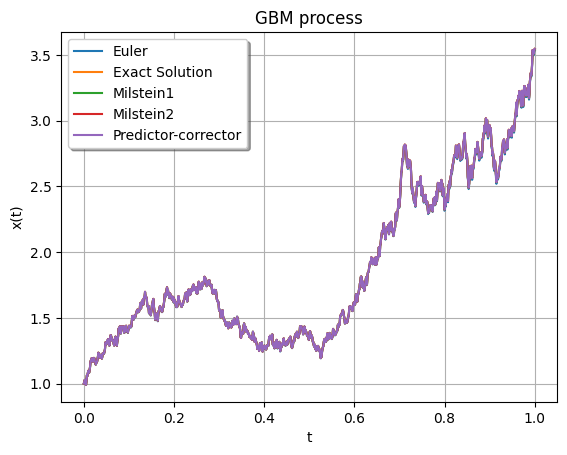

In [84]:
theta1 = 1
theta2 = 1/2
params = [theta1, theta2]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)


BSMp = BSMprocess(params, T, Nx, Nt, init_state)
t_data, x_data = BSMp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = BSMp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = BSMp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = BSMp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = BSMp.PredictorCorrectorSolution(dwt, 1/2, 1/2)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("GBM process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Compare the different approximations and the exact solution Brownian motion
for different levels of discretization
$$
N=\{2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768\}
$$
being the number of subintervals of $[0,1]$.
As the result provide the table with maximum absolute difference.


In [85]:
def approxs(model, nt):

    dwt = np.random.normal(0, 1, size = (model.Nt, model.Nx)) * np.sqrt(model.T/model.Nt)

    all_approxs = {
        'exact': dict(zip(['t_data', 'x_data'], model.ExactSolution(dwt))),
        'euler': dict(zip(['t_data', 'x_data'], model.EulerSolution(dwt))),
        'milstein1': dict(zip(['t_data', 'x_data'], model.Milstein1Solution(dwt))),
        'milstein2': dict(zip(['t_data', 'x_data'], model.Milstein2Solution(dwt))),
        'Predictor-corrector': dict(zip(['t_data', 'x_data'], model.PredictorCorrectorSolution(dwt, 1/2, 1/2)))
    }

    return all_approxs

def df_res(results):

    diffs = []
    for Nt, res in results.items():
        exact_solution = res['exact']['x_data']
        for method, data in res.items():
            if method != 'exact':
                diff_values = np.abs(data['x_data'] - exact_solution)
                diffs.append([method, Nt, diff_values.min(), diff_values.max(), diff_values.mean()])
    
    return pd.DataFrame(diffs, columns=['method', 'discretization', 'min', 'max', 'mean'])

def display_res(exp_df):
    
    dfs_by_discretization = {}
    
    for dis, group in exp_df.groupby('discretization'):
        dfs_by_discretization[dis] = group.drop(columns=['discretization'])
        
    for dis, df in dfs_by_discretization.items():
        print(f"\nDiscretization: {dis}")
        display(df)


In [86]:
T, Nx, x0 = 1, 1, 1
init_state = np.full(Nx, x0)
params = [1, 1/2]
Ns = [2, 4, 8, 128, 256, 1024, 8192, 16384, 32768]

result = {}

for Nt in Ns:
    # dwt = np.random.normal(loc=0, scale=1, size=(Nt, Nx)) * np.sqrt(T / Nt)
    BSMp = BSMprocess(params, T, Nx, Nt, init_state)
    result[Nt] = approxs(BSMp, Nt)

exp_df = df_res(result)
display_res(exp_df)
# for dis, group in exp_df.groupby('discretization'):
#     print(f"\nDiscretization: {dis}")
#     print(group.drop(columns=['discretization']).to_string(index=False))


Discretization: 2


,method,min,max,mean
0,euler,0.0,0.060137,0.037486
1,milstein1,0.0,0.160154,0.104430
2,milstein2,0.0,0.006680,0.003478
3,Predictor-corrector,0.0,0.004156,0.002741



Discretization: 4


,method,min,max,mean
4,euler,0.0,0.028820,0.016302
5,milstein1,0.0,0.170046,0.070547
6,milstein2,0.0,0.024408,0.011117
7,Predictor-corrector,0.0,0.003014,0.001054



Discretization: 8


,method,min,max,mean
8,euler,0.0,0.035255,0.016734
9,milstein1,0.0,0.065209,0.023954
10,milstein2,0.0,0.004079,0.001667
11,Predictor-corrector,0.0,0.008270,0.004145



Discretization: 128


,method,min,max,mean
12,euler,0.0,0.030466,0.006609
13,milstein1,0.0,0.018142,0.006532
14,milstein2,0.0,0.001463,0.000501
15,Predictor-corrector,0.0,0.000685,0.000244



Discretization: 256


,method,min,max,mean
16,euler,0.0,0.100364,0.045968
17,milstein1,0.0,0.025426,0.013590
18,milstein2,0.0,0.000732,0.000192
19,Predictor-corrector,0.0,0.002398,0.001010



Discretization: 1024


,method,min,max,mean
20,euler,0.0,0.012259,0.003758
21,milstein1,0.0,0.000770,0.000203
22,milstein2,0.0,0.000061,0.000023
23,Predictor-corrector,0.0,0.000172,0.000047



Discretization: 8192


,method,min,max,mean
24,euler,0.0,0.006298,0.001952
25,milstein1,0.0,0.000459,0.000145
26,milstein2,0.0,0.000027,0.000005
27,Predictor-corrector,0.0,0.000067,0.000018



Discretization: 16384


,method,min,max,mean
28,euler,0.0,0.002693,0.000967
29,milstein1,0.0,0.000065,0.000019
30,milstein2,0.0,0.000009,0.000003
31,Predictor-corrector,0.0,0.000009,0.000002



Discretization: 32768


,method,min,max,mean
32,euler,0.0,0.000763,3.324241e-04
33,milstein1,0.0,0.000013,5.210870e-06
34,milstein2,0.0,0.000002,5.199314e-07
35,Predictor-corrector,0.0,0.000003,7.046399e-07


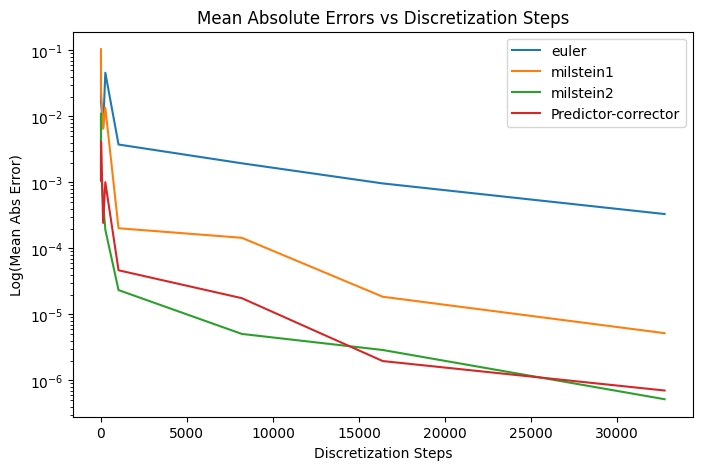

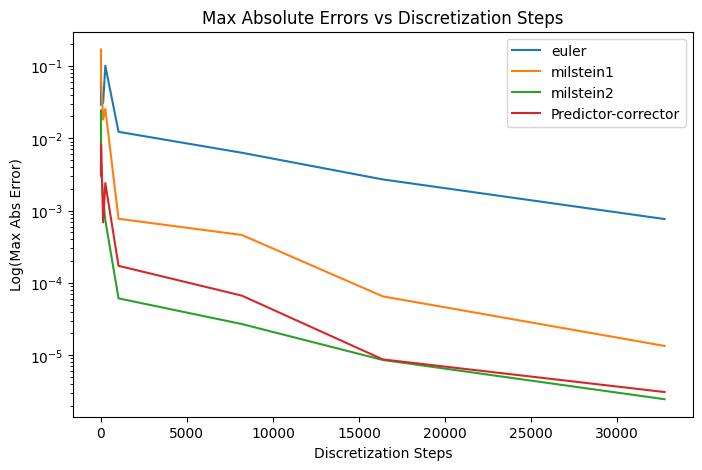

In [87]:
plt.figure(figsize=(8, 5))
for method in exp_df['method'].unique():
    data_subset = exp_df[exp_df['method'] == method]
    plt.plot(data_subset['discretization'], data_subset['mean'], label=method)

plt.yscale('log')
plt.xlabel('Discretization Steps')
plt.ylabel('Log(Mean Abs Error)')
plt.title('Mean Absolute Errors vs Discretization Steps')
plt.legend()
plt.show()


plt.figure(figsize=(8, 5))
for method in exp_df['method'].unique():
    data_subset = exp_df[exp_df['method'] == method]
    plt.plot(data_subset['discretization'], data_subset['max'], label=method)

plt.yscale('log')
plt.xlabel('Discretization Steps')
plt.ylabel('Log(Max Abs Error)')
plt.title('Max Absolute Errors vs Discretization Steps')
plt.legend()
plt.show()

Task. Conduct a study of the influence of the choice of values $\alpha$ and $\eta$ ​​on the accuracy of the  solution and plot a 3D graph where the x-axis is $α$'s values, y-axis is $\eta$'s values, and z-axis are maximum absolute difference between the exact solution and the predictor-corrector approximation.



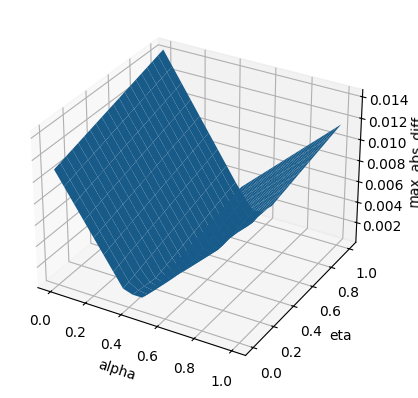

In [88]:
def study_influece(model, alphas, etas):
    dt = model.T / model.Nt
    dwt = np.random.normal(0, 1, size=(model.Nt, model.Nx)) * np.sqrt(dt)

    t, x_exact = model.ExactSolution(dwt)

    diff = np.zeros((len(alphas), len(etas)))

    for i, alpha in enumerate(alphas):
        for j, eta in enumerate(etas):
            t, x_approx = model.PredictorCorrectorSolution(dwt, eta, alpha)
            diff[i, j] = np.max(np.abs(x_approx - x_exact))
            
    return diff

T, Nx, Nt = 1, 1, 1000
theta1 = 1
theta2 = 1/2
params = [theta1, theta2]

alphas = np.linspace(0, 1, 20)
etas = np.linspace(0, 1, 20)
BSMp = BSMprocess(params, T, Nx, Nt)

diff = study_influece(BSMp, alphas, etas)

alpha_grid, eta_grid = np.meshgrid(alphas, etas)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(alpha_grid, eta_grid, diff)
ax.set_xlabel('alpha')
ax.set_ylabel('eta')
ax.set_zlabel('max_abs_diff')
plt.show()

Task 2.  Repeat the Task 1 for the Cox-Ingersoll-Ross process
$$
dX_t = (\theta_1 - \theta_2X_t)dt + \theta_3 \sqrt{ X_t}dW_t, X_0 = 10, (\theta_1, \theta_2, \theta_3) = (6, 3, 2).
$$

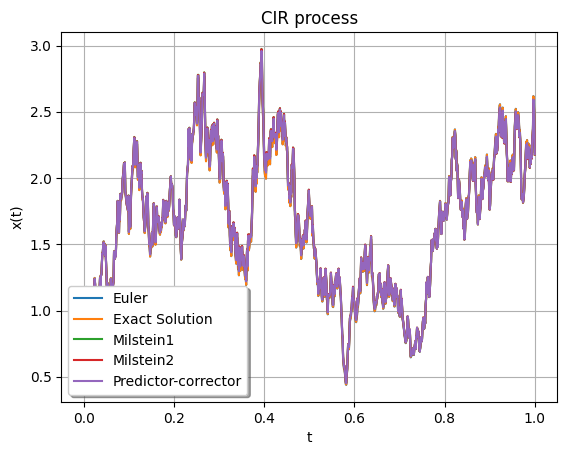

In [89]:
theta1 = 6
theta2 = 3
theta3 = 2
params = [theta1, theta2, theta3]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)

CIRp = CIRprocess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = CIRp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = CIRp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = CIRp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = CIRp.PredictorCorrectorSolution(dwt, 0.4, 0.6)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("CIR process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Compare the speed of convergence for four schemes from Task 1 with extract solution on the graph where the x-axis is  log(N) values, y-axis is  X(t). See example in the study aid.

In [90]:
result = {}

for Nt in Ns:
    result[Nt] = approxs(CIRp, Nt)

exp_df = df_res(result)
display_res(exp_df)


Discretization: 2


,method,min,max,mean
0,euler,0.0,0.002810,0.001042
1,milstein1,0.0,0.038869,0.013722
2,milstein2,0.0,0.039701,0.013504
3,Predictor-corrector,0.0,0.038787,0.013459



Discretization: 4


,method,min,max,mean
4,euler,0.0,0.003760,0.001321
5,milstein1,0.0,0.042543,0.013310
6,milstein2,0.0,0.042677,0.013732
7,Predictor-corrector,0.0,0.042727,0.013981



Discretization: 8


,method,min,max,mean
8,euler,0.0,0.004246,0.001203
9,milstein1,0.0,0.037043,0.008976
10,milstein2,0.0,0.035735,0.008952
11,Predictor-corrector,0.0,0.035802,0.008952



Discretization: 128


,method,min,max,mean
12,euler,0.0,0.007695,0.001498
13,milstein1,0.0,0.027470,0.010942
14,milstein2,0.0,0.028620,0.011709
15,Predictor-corrector,0.0,0.027898,0.011269



Discretization: 256


,method,min,max,mean
16,euler,0.0,0.003782,0.001457
17,milstein1,0.0,0.027451,0.006830
18,milstein2,0.0,0.027516,0.006884
19,Predictor-corrector,0.0,0.027854,0.006997



Discretization: 1024


,method,min,max,mean
20,euler,0.0,0.004407,0.001526
21,milstein1,0.0,0.027432,0.008474
22,milstein2,0.0,0.025897,0.008254
23,Predictor-corrector,0.0,0.025265,0.007907



Discretization: 8192


,method,min,max,mean
24,euler,0.0,0.007485,0.001938
25,milstein1,0.0,0.023056,0.007651
26,milstein2,0.0,0.022416,0.007889
27,Predictor-corrector,0.0,0.022142,0.007821



Discretization: 16384


,method,min,max,mean
28,euler,0.0,0.003401,0.001370
29,milstein1,0.0,0.037488,0.010997
30,milstein2,0.0,0.037298,0.011061
31,Predictor-corrector,0.0,0.037017,0.010928



Discretization: 32768


,method,min,max,mean
32,euler,0.0,0.011232,0.003933
33,milstein1,0.0,0.023425,0.009195
34,milstein2,0.0,0.024958,0.009476
35,Predictor-corrector,0.0,0.024575,0.009355


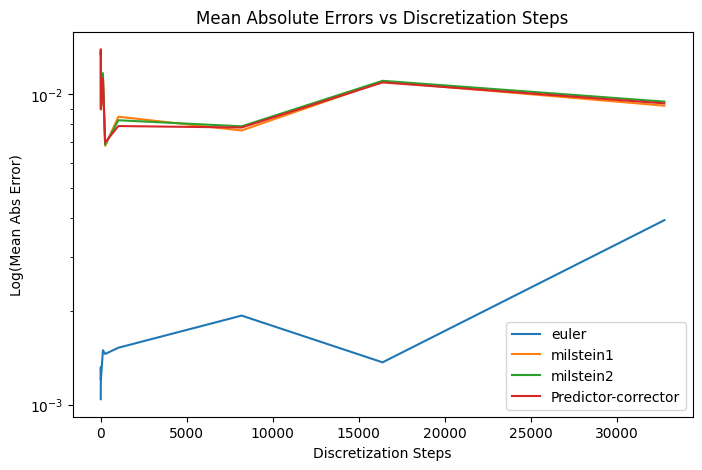

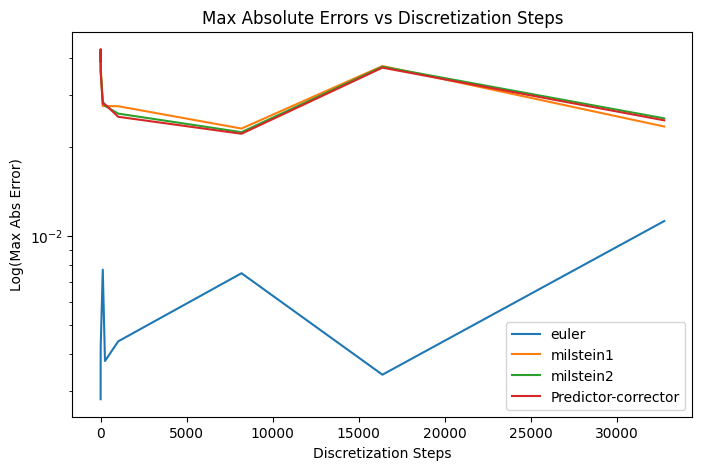

In [91]:
plt.figure(figsize=(8, 5))
for method in exp_df['method'].unique():
    data_subset = exp_df[exp_df['method'] == method]
    plt.plot(data_subset['discretization'], data_subset['mean'], label=method)

plt.yscale('log')
plt.xlabel('Discretization Steps')
plt.ylabel('Log(Mean Abs Error)')
plt.title('Mean Absolute Errors vs Discretization Steps')
plt.legend()
plt.show()


plt.figure(figsize=(8, 5))
for method in exp_df['method'].unique():
    data_subset = exp_df[exp_df['method'] == method]
    plt.plot(data_subset['discretization'], data_subset['max'], label=method)

plt.yscale('log')
plt.xlabel('Discretization Steps')
plt.ylabel('Log(Max Abs Error)')
plt.title('Max Absolute Errors vs Discretization Steps')
plt.legend()
plt.show()

Task 3. Generate 100 paths using conditional distribution of
* Ornstein-Uhlenbeck process $θ = (1, 1, 0.5)$,
* Geometric Brownian motion process $θ = (0.3, 0.1)$,
* Cox-Ingersoll-Ross process $θ = (0.4, 0.3, 0.2)$

with $X_0=0.5$.
Plot the random path for each process.

In [112]:
Nx = 100
Nt = 300

T = 1

params_OU = [1, 1, 0.5]
params_BSM = [0.3, 0.1]
params_CIR = [0.4, 0.3, 0.2]

init_state = 0.5 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)
BSMp = BSMprocess(params_BSM, T, Nx, Nt, init_state)
CIRp = CIRprocess(params_CIR, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.PathGenerator()
t_data, x_data_BSM = BSMp.PathGenerator()
t_data, x_data_CIR = CIRp.PathGenerator()

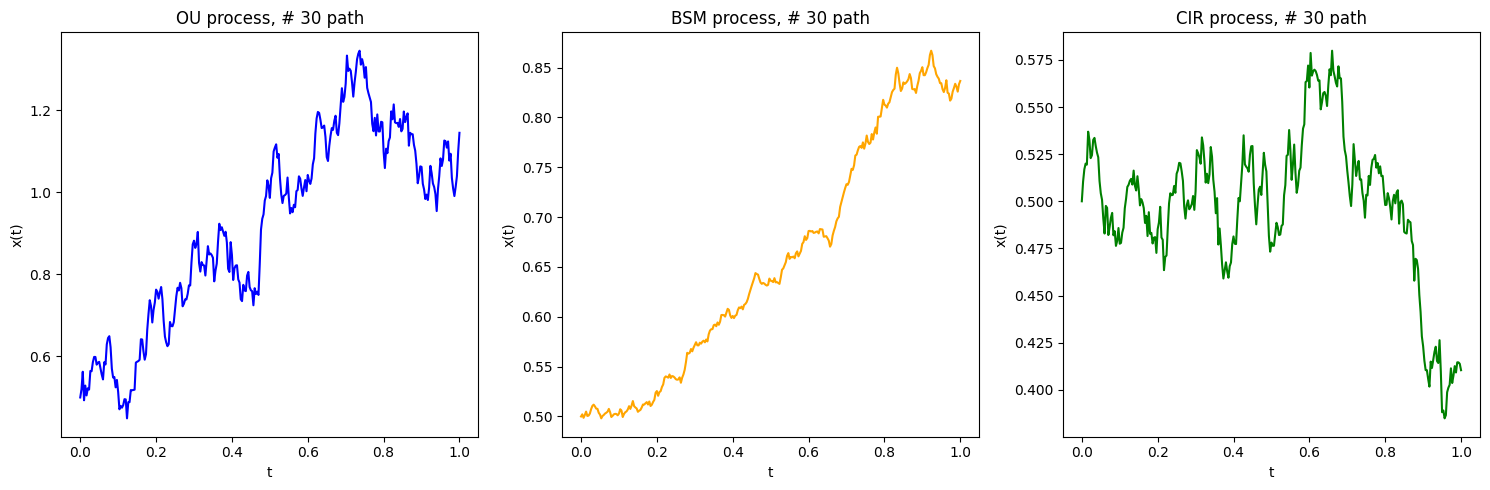

In [113]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

n = np.random.randint(0, Nx)

axs[0].plot(t_data, x_data_OU[:,n], color='blue')
axs[0].set_title(f'OU process, # {n} path')
axs[0].set_xlabel('t')
axs[0].set_ylabel('x(t)')

axs[1].plot(t_data, x_data_BSM[:,n], color='orange')
axs[1].set_title(f'BSM process, # {n} path')
axs[1].set_xlabel('t')
axs[1].set_ylabel('x(t)')

axs[2].plot(t_data, x_data_CIR[:,n], color='green')
axs[2].set_title(f'CIR process, # {n} path')
axs[2].set_xlabel('t')
axs[2].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

Task. Using the class template from Task 1, create class and design the path generator for one from the following processes:

1.   Modified CIR model;
2.   Chan-Karolyi-Longstaff-Sanders family of models;
1.   Nonlinear mean reversion Ait-Sahalia model;
2.   Jacobi diffusion process;
1.   Ahn and Gao (inverse of Feller’s square root) model;
2.   Radial Ornstein-Uhlenbeck process.

In [94]:
class CKLSprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3, theta4]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2] * x ** self.params[3]
        self.bxt_x = lambda x: -self.params[0]
        self.bxt_xx = lambda x: 0
        self.sigmaxt_x = lambda x: self.params[2] * self.params[3] * x ** (self.params[3] - 1)
        self.sigmaxt_xx = lambda x: self.params[2] * self.params[3] * (self.params[3] - 1) * x ** (self.params[3] - 2)

    def DefaultInitState(self):
        return np.ones(self.Nx)

    def StationaryState(self):
        theta1, theta2, theta3, theta4 = self.params

        nu = 2 * theta1 / (theta3 ** 2) if theta3 != 0 else 1

        result = t.rvs(df=nu, size=self.Nx) * theta2
        return result

    def SampleFromDensity(self, x0, t1, t0):
        theta1, theta2, theta3, theta4 = self.params

        decay_factor = np.exp(-theta1 * (t1 - t0))

        result = np.zeros(self.Nx)
        for j in range(self.Nx):
            accept = False
            while not accept:
                x_candidate = t.rvs(df=2 * theta1 / theta3 ** 2) if theta3 != 0 else theta2
                
                target_density = np.exp(-0.5 * ((x_candidate - theta2) ** 2) / (theta3 ** 2))
                proposal_density = t.pdf(x_candidate, df=2 * theta1 / theta3 ** 2) if theta3 != 0 else 1
                acceptance_ratio = target_density / proposal_density

                if uniform.rvs() < acceptance_ratio:
                    result[j] = x_candidate * decay_factor
                    accept = True

        return result

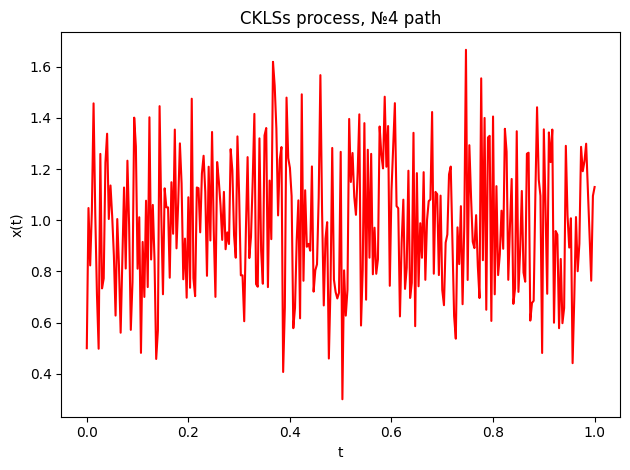

In [95]:
Nx = 100
Nt = 300

T = 1

params_CKLS = [0.1, 1.0, 0.2, 0.5]

init_state = 0.5 * np.ones(Nx)

CKLS = CKLSprocess(params_CKLS, T, Nx, Nt, init_state)

t_data, x_data_CKLS = CKLS.PathGenerator()

n = np.random.randint(0, Nx)

plt.plot(t_data, x_data_CKLS[:,n], color='red')
plt.title(f'CKLSs process, №{n} path')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.tight_layout()
plt.show()

In [96]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(len(x))/float(len(x))
    return x, y

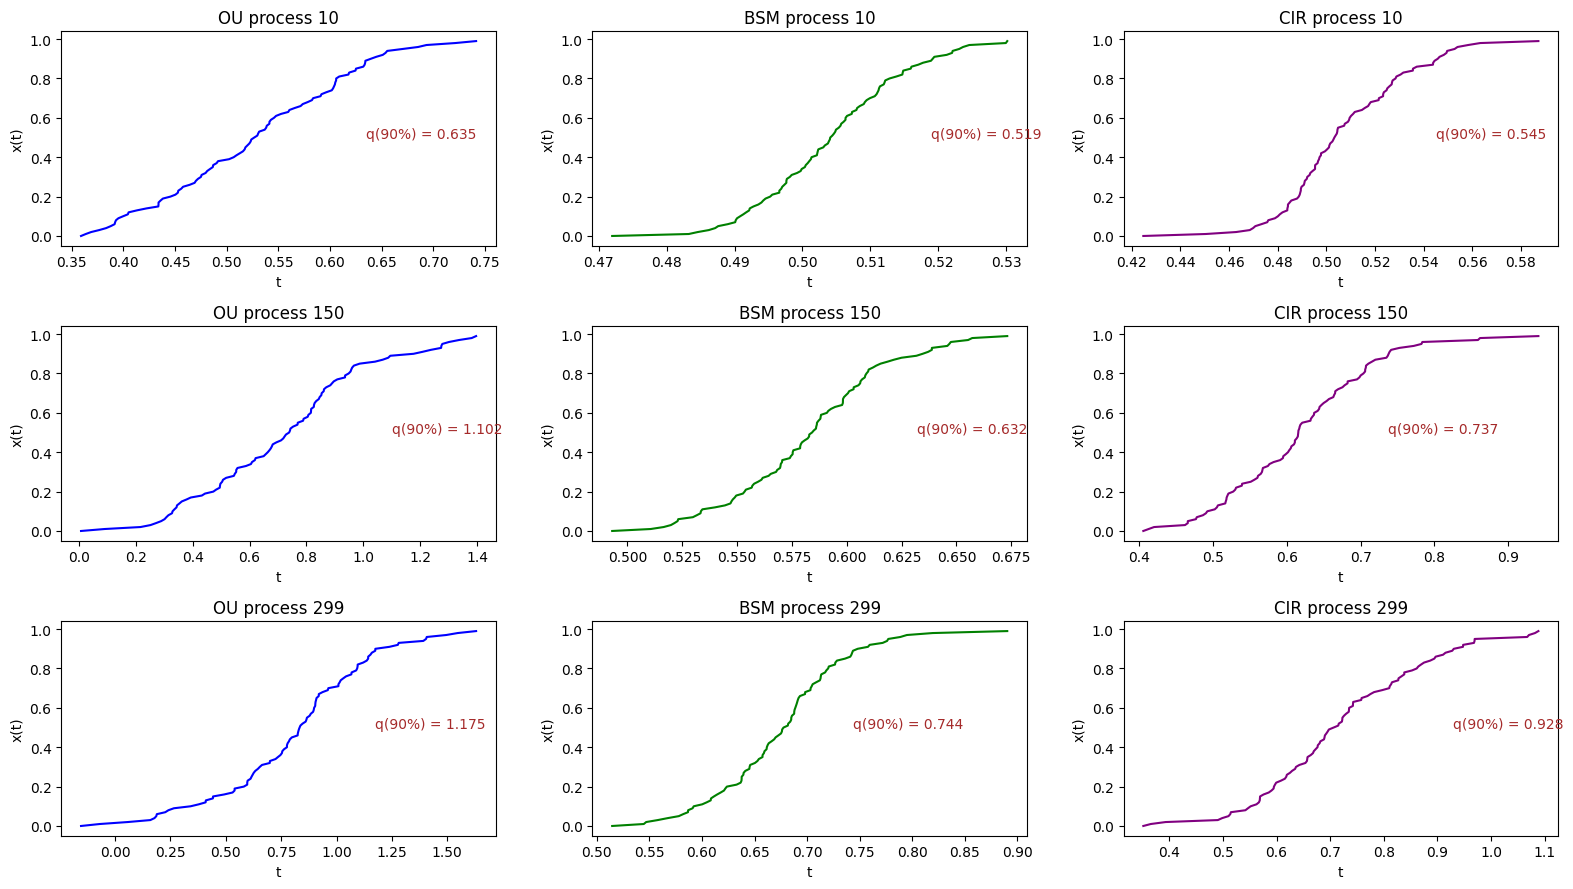

In [97]:
#cdf function and 90% quantile

#distributions become more widely and change with time

fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 10

axs[0][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[0][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[0][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[0][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[0][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[0][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[0][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[0][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[0][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = Nt // 2
axs[1][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[1][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[1][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[1][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[1][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[1][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[1][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[1][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[1][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = Nt - 1
axs[2][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[2][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[2][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[2][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[2][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[2][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[2][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[2][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[2][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

for k in range(0, 3):
    for j in range(0, 3):
        #axs[k][j].set_ylim(0, 1)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()
plt.show()

Task. Perform the Kolmogorov-Smirnov test for two samples and present your conclusions. Add vertical lines (90\%-quantile) into plots.
Resize the range on the X-axis so that all curves for one process have the same range.    


Kolmogorov-Smirnov test results for n=10:
OU vs BSM: D=0.4700, p-value=0.0000
OU vs CIR: D=0.4100, p-value=0.0000
BSM vs CIR: D=0.2800, p-value=0.0007

Kolmogorov-Smirnov test results for n=150:
OU vs BSM: D=0.5000, p-value=0.0000
OU vs CIR: D=0.4000, p-value=0.0000
BSM vs CIR: D=0.3100, p-value=0.0001

Kolmogorov-Smirnov test results for n=299:
OU vs BSM: D=0.5500, p-value=0.0000
OU vs CIR: D=0.3500, p-value=0.0000
BSM vs CIR: D=0.2900, p-value=0.0004


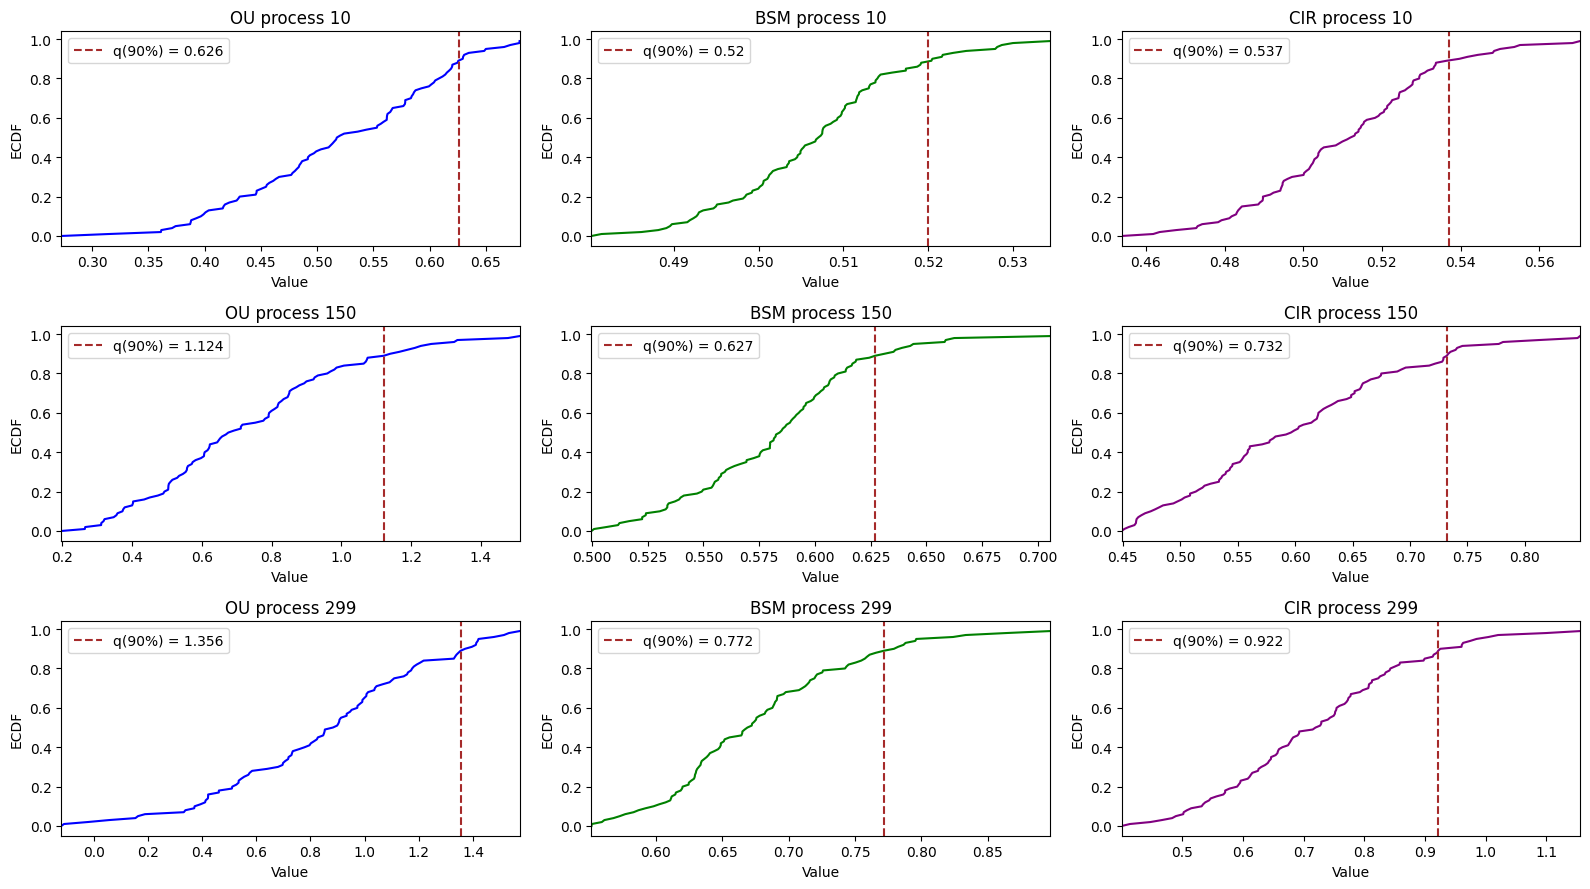

In [118]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(len(x)) / float(len(x))
    return x, y

fig, axs = plt.subplots(3, 3, figsize=(16, 9))
n_values = [10, Nt // 2, Nt - 1]

for i, n in enumerate(n_values):
    
    # OU Process
    x_ou, y_ou = ecdf(x_data_OU[n])
    axs[i][0].plot(x_ou, y_ou, color='blue')
    axs[i][0].set_title(f'OU process {n}')
    ou_quantile = round(np.quantile(x_data_OU[n], 0.9), 3)
    axs[i][0].axvline(ou_quantile, color='brown', linestyle='--', label=f'q(90%) = {ou_quantile}')
    axs[i][0].legend()
    axs[i][0].set_xlim(np.min(x_ou), np.max(x_ou))  # Установка диапазона оси X по данным графика

    # BSM Process
    x_bsm, y_bsm = ecdf(x_data_BSM[n])
    axs[i][1].plot(x_bsm, y_bsm, color='green')
    axs[i][1].set_title(f'BSM process {n}')
    bsm_quantile = round(np.quantile(x_data_BSM[n], 0.9), 3)
    axs[i][1].axvline(bsm_quantile, color='brown', linestyle='--', label=f'q(90%) = {bsm_quantile}')
    axs[i][1].legend()
    axs[i][1].set_xlim(np.min(x_bsm), np.max(x_bsm)) 

    # CIR Process
    x_cir, y_cir = ecdf(x_data_CIR[n])
    axs[i][2].plot(x_cir, y_cir, color='purple')
    axs[i][2].set_title(f'CIR process {n}')
    cir_quantile = round(np.quantile(x_data_CIR[n], 0.9), 3)
    axs[i][2].axvline(cir_quantile, color='brown', linestyle='--', label=f'q(90%) = {cir_quantile}')
    axs[i][2].legend()
    axs[i][2].set_xlim(np.min(x_cir), np.max(x_cir)) 

    # Тест Колмогорова-Смирнова
    ks_ou_bsm = ks_2samp(x_data_OU[n], x_data_BSM[n])
    ks_ou_cir = ks_2samp(x_data_OU[n], x_data_CIR[n])
    ks_bsm_cir = ks_2samp(x_data_BSM[n], x_data_CIR[n])

    print(f"\nKolmogorov-Smirnov test results for n={n}:")
    print(f"OU vs BSM: D={ks_ou_bsm.statistic:.4f}, p-value={ks_ou_bsm.pvalue:.4f}")
    print(f"OU vs CIR: D={ks_ou_cir.statistic:.4f}, p-value={ks_ou_cir.pvalue:.4f}")
    print(f"BSM vs CIR: D={ks_bsm_cir.statistic:.4f}, p-value={ks_bsm_cir.pvalue:.4f}")

for k in range(3):
    for j in range(3):
        axs[k][j].set_xlabel('Value')
        axs[k][j].set_ylabel('ECDF')

plt.tight_layout()
plt.show()

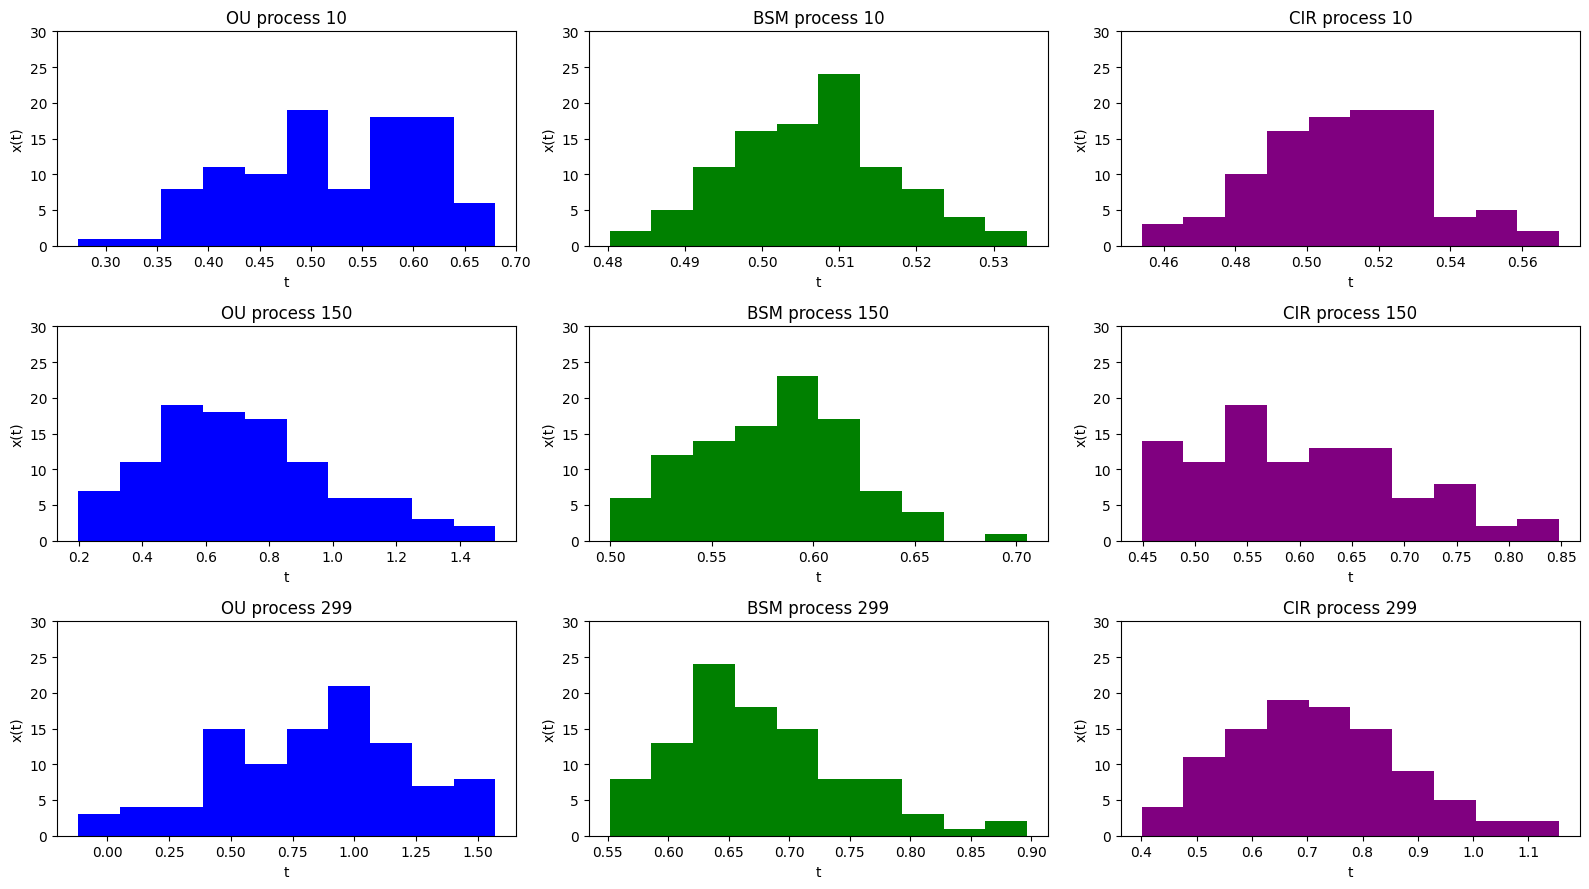

In [117]:
#density function
fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 10

axs[0][0].hist(x_data_OU[n], color='blue')
axs[0][0].set_title(f'OU process {n}')

axs[0][1].hist(x_data_BSM[n], color='green')
axs[0][1].set_title(f'BSM process {n}')

axs[0][2].hist(x_data_CIR[n], color='purple')
axs[0][2].set_title(f'CIR process {n}')

n = Nt // 2
axs[1][0].hist(x_data_OU[n], color='blue')
axs[1][0].set_title(f'OU process {n}')

axs[1][1].hist(x_data_BSM[n], color='green')
axs[1][1].set_title(f'BSM process {n}')

axs[1][2].hist(x_data_CIR[n], color='purple')
axs[1][2].set_title(f'CIR process {n}')

n = Nt - 1
axs[2][0].hist(x_data_OU[n], color='blue')
axs[2][0].set_title(f'OU process {n}')

axs[2][1].hist(x_data_BSM[n], color='green')
axs[2][1].set_title(f'BSM process {n}')

axs[2][2].hist(x_data_CIR[n], color='purple')
axs[2][2].set_title(f'CIR process {n}')

for k in range(0, 3):
    for j in range(0, 3):
        axs[k][j].set_ylim(0, 30)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

Task. Perform a normality test on the histograms and present your conclusions.

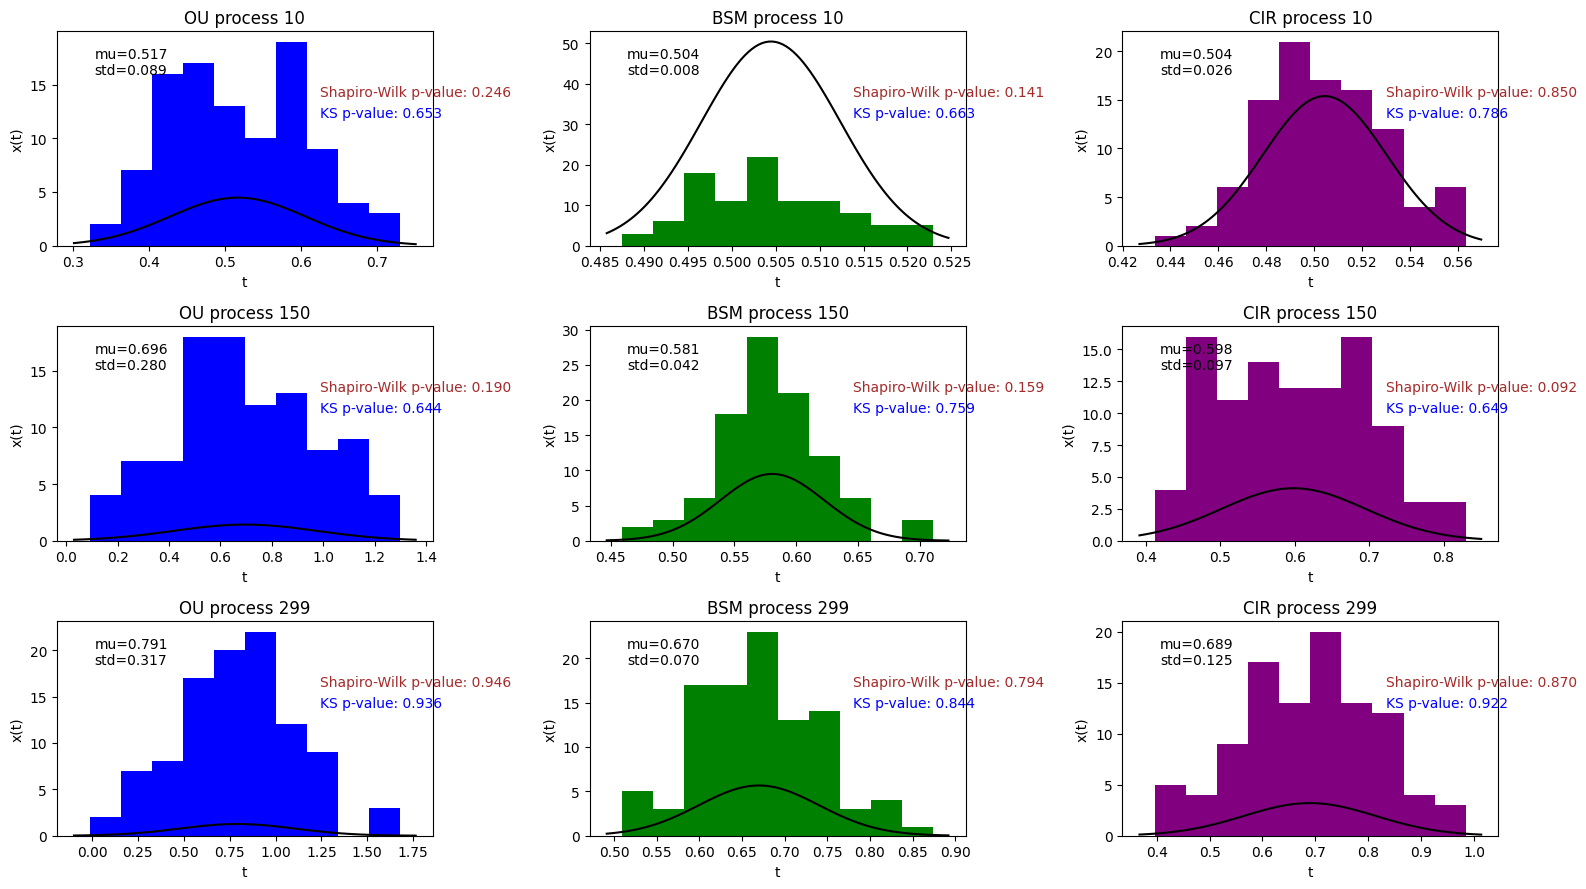

In [109]:
fig, axs = plt.subplots(3, 3, figsize=(16, 9))

ns = [10, Nt // 2, Nt - 1]
models = [x_data_OU, x_data_BSM, x_data_CIR]
names = ['OU', 'BSM', 'CIR']
colors = ['blue', 'green', 'purple']

for k, n in enumerate(ns):
    for j, (model, model_name, color) in enumerate(zip(models, names, colors)):
        axs[k][j].hist(model[n], color=color)
        mu, std = norm.fit(model[n])
        
        xmin, xmax = axs[k][j].get_xlim()
        x = np.linspace(xmin, xmax, len(model[n]))
        p = norm.pdf(x, mu, std)
        axs[k][j].plot(x, p, color='black')
        axs[k][j].text(0.1, 0.8, f'mu={mu:.3f}\nstd={std:.3f}', color='black', 
                       transform=axs[k][j].transAxes)

        # Shapiro test
        stat, p_value = shapiro(model[n])
        axs[k][j].text(0.7, 0.7, f'Shapiro-Wilk p-value: {p_value:.3f}', color='brown' , 
                       transform=axs[k][j].transAxes)
        
        # Kolmogorov test
        ks_stat, ks_p_value = kstest(model[n], 'norm', args=(mu, std))
        axs[k][j].text(0.7, 0.6, f'KS p-value: {ks_p_value:.3f}', color='blue',  
                       transform=axs[k][j].transAxes)

        axs[k][j].set_title(f'{model_name} process {n}')
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()

plt.show()